In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap scikit-multilearn

1.   **Import anything**

In [16]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import shap
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.datasets import make_multilabel_classification
import re

In [7]:
csv_final='/content/drive/MyDrive/TEAM_ML/ML/DataSet/data_file_csv_final.csv'

In [8]:
data = pd.read_csv(csv_final, encoding='utf-8')
data = data[['end_destination', 'startplus',
                        'receipt-ride','hour',
                         'startpos1', 'startpos2', 'endplus']]
train, test = train_test_split(data, test_size=0.2, random_state=1)
train, val = train_test_split(train, test_size=0.25, random_state=1)
# feature Matrix, target vector 생성
target = 'endplus'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# 확인
print("feature Matrix: ", X_train.shape, X_val.shape, X_test.shape)
print("target vector: ", y_train.shape, y_val.shape, y_test.shape)

feature Matrix:  (1242, 6) (415, 6) (415, 6)
target vector:  (1242,) (415,) (415,)


2-1.   **LightGBM**

In [9]:
lgb_dtrain = lgb.Dataset(data = X_train, label = y_train)
lgb_dtest = lgb.Dataset(data = X_test, label = y_test)
lgb_param = {
    'learning_rate' : 0.01,
    'objective' : 'regression',
    'verbose' : -1,
    'random_state' : 42
}
lgb_model = lgb.train(
    params = lgb_param,
    train_set = lgb_dtrain,
    valid_sets=[lgb_dtest]
)
lgb_model_predict = lgb_model.predict(X_test)
print(
    "RMSE : {}".format(sqrt(mean_squared_error(lgb_model_predict, y_test)))
)

[1]	valid_0's l2: 3491.89
[2]	valid_0's l2: 3466.99
[3]	valid_0's l2: 3442.24
[4]	valid_0's l2: 3418.03
[5]	valid_0's l2: 3394.36
[6]	valid_0's l2: 3371.2
[7]	valid_0's l2: 3349.03
[8]	valid_0's l2: 3326.78
[9]	valid_0's l2: 3305.59
[10]	valid_0's l2: 3284.56
[11]	valid_0's l2: 3263.84
[12]	valid_0's l2: 3243.73
[13]	valid_0's l2: 3223.85
[14]	valid_0's l2: 3204.62
[15]	valid_0's l2: 3187.03
[16]	valid_0's l2: 3168.11
[17]	valid_0's l2: 3151.43
[18]	valid_0's l2: 3133.92
[19]	valid_0's l2: 3117.22
[20]	valid_0's l2: 3101.6
[21]	valid_0's l2: 3085.01
[22]	valid_0's l2: 3069.64
[23]	valid_0's l2: 3054.07
[24]	valid_0's l2: 3038.61
[25]	valid_0's l2: 3024.35
[26]	valid_0's l2: 3010.64
[27]	valid_0's l2: 2996.75
[28]	valid_0's l2: 2984.5
[29]	valid_0's l2: 2970.89
[30]	valid_0's l2: 2957.66
[31]	valid_0's l2: 2944.35
[32]	valid_0's l2: 2930.96
[33]	valid_0's l2: 2918.47
[34]	valid_0's l2: 2907.07
[35]	valid_0's l2: 2895
[36]	valid_0's l2: 2883.92
[37]	valid_0's l2: 2871.15
[38]	valid_0's l

In [10]:
explainer = shap.TreeExplainer(lgb_model)
expected_value = explainer.expected_value
if isinstance(expected_value, list) :
    expected_value = expected_value[1]
print(f"Explainer expected value : {expected_value}")

Explainer expected value : [7576.92431562]


In [11]:
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.force_plot(expected_value, shap_values[1, :], X_test.iloc[1, :])

In [17]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


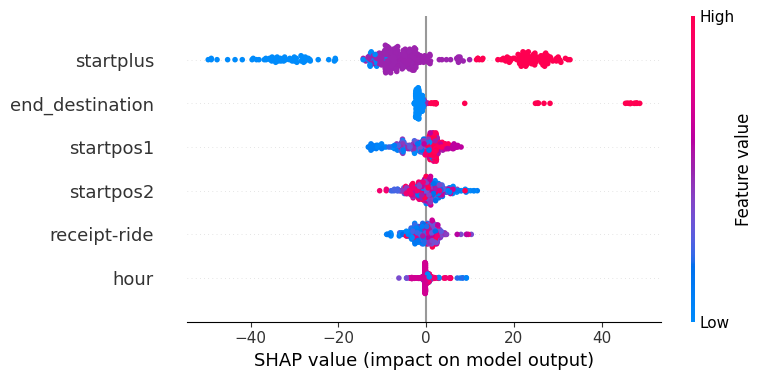

In [18]:
shap.summary_plot(shap_values, X_test)

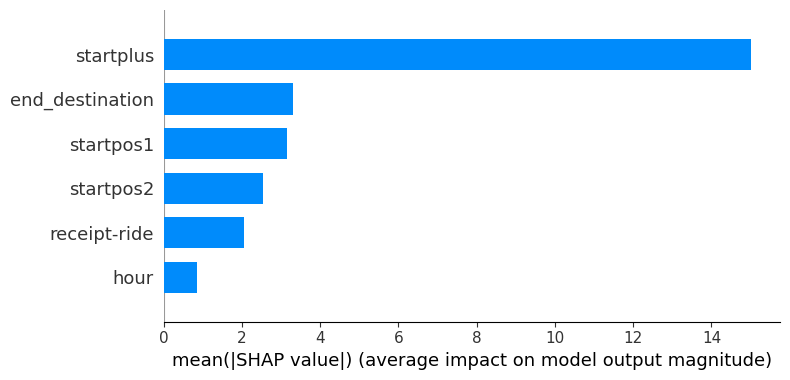

In [19]:
shap.summary_plot(shap_values, X_test, plot_type = 'bar')

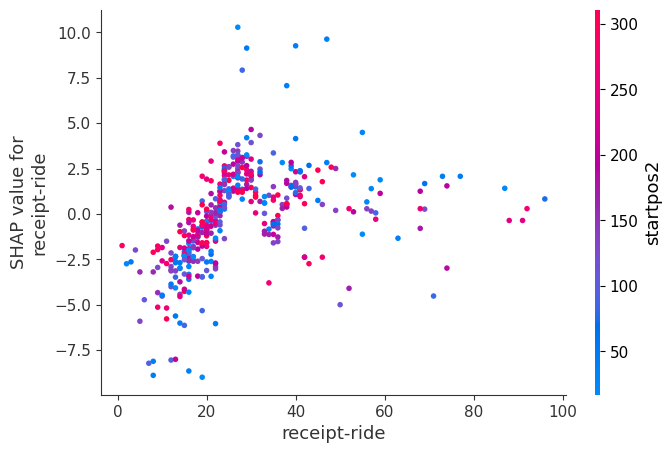

In [20]:
shap.dependence_plot(
    'receipt-ride',
    shap_values,
    X_test
)

2-2.   **XGBoost**

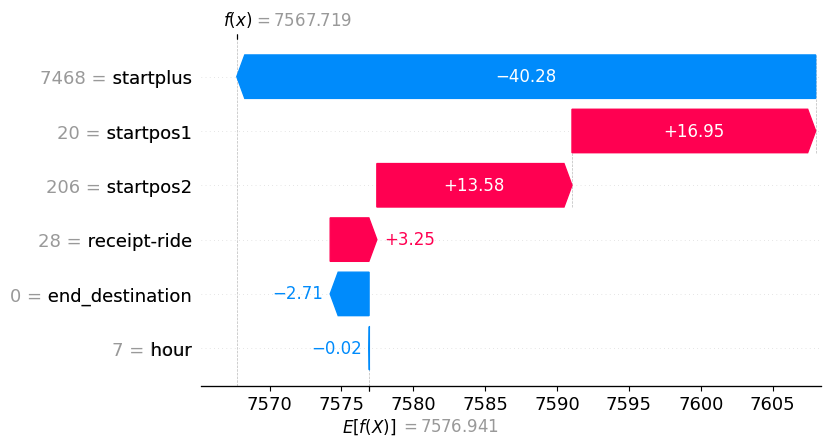

In [21]:
xgbmodel = xgboost.XGBRegressor().fit(X_train, y_train)
explainer = shap.Explainer(xgbmodel)
shap_values2 = explainer(X_train)
shap.plots.waterfall(shap_values2[0])

In [22]:
shap.initjs()
shap.plots.force(shap_values2[0])

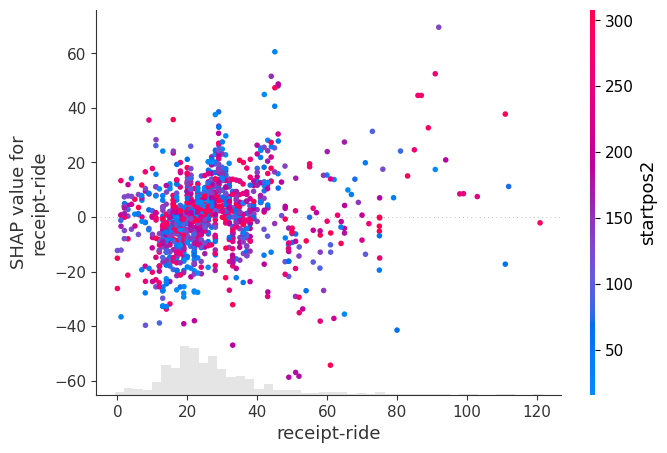

In [23]:
shap.plots.scatter(shap_values2[:, 'receipt-ride'],
                  color = shap_values2)